This notebook is going to contain a possible pipeline to perform churn prediction.

First of all, let's download all the most relevant libraries that can be useful to perform the task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, f1_score, precision_score, roc_curve, auc, confusion_matrix, classification_report, log_loss
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

## Dataset Download and Preparation

In this section, we are going to report a series of methods to download the dataset in csv format and to perform some operations, i.e. imputation of missing values, handling of outliers. The code is tailored for a specific dataset, but can be adapted to other datasets.

In [17]:
def download_dataset(url):
    d = pd.read_csv(url) # POTENTIALLY: apply parse_dates, based on the dataset format
    ids = d.id
    d.drop(['id'], axis = 1, inplace = True)
    print(d.info(show_counts = True))
    return d, ids

In [18]:
train, _ = download_dataset("train.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB
None


This particular dataset does not have missing values: if the dataset contains them, one needs to decide for the right imputation strategy. For example, if the dataset contains transactions for each user, and some of them are missing, one could perform a linear imputation, as to mimic the potential trend in the transactions. One needs to check if all the dates are present and check that they are consistent and that no outliers are present.

In [19]:
def categorical_handling(categories, names, df):
    for c, n in zip(categories, names):
        ohe = LabelEncoder() #OneHotEncoder(sparse_output = False)
        encs = ohe.fit_transform(df[[c]])
        encs_df = pd.DataFrame(encs)
        n_col = len(encs_df.columns)
        cols = []
        for nn in range(0, n_col):
            cols.append(""+n+""+str(nn))
        encs_df.columns = cols
        df = pd.concat([df, encs_df], axis = 1)
        df.drop(c, axis = 1, inplace = True)
    return df

In [20]:
catv = ['Geography', 'Gender'] #, 'IsActiveMember', 'HasCrCard', 'NumOfProducts']
names = ['Geo', 'Gen'] #, 'Act', 'Cred', 'Prod']
train = categorical_handling(catv, names, train)

/nfs/home/medoro/Churn-detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/nfs/home/medoro/Churn-detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
def frequency_encoding(df, cols):
    for c in cols:
        fq = df.groupby(c).size()/len(df)
        df.loc[:, "{}_freq_encode".format(c)] = df[c].map(fq)
        df.drop(c, axis = 1, inplace = True)
    return df

In [22]:
cols = ['Surname', 'CustomerId']
train.drop(cols, axis = 1, inplace = True)
#train = frequency_encoding(train, cols)

Other features can also be created, but the process is custom to the specific dataset.

## Train-Val Split

In this section, we are going to define some functions to create the training and validation sets.

In [23]:
def train_val_sets(df, target_col, resampling = None):
    y = df[target_col]
    X = df.drop(target_col, axis = 1)
    if isinstance(resampling, str) and resampling.lower() == "over":
        sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
    elif isinstance(resampling, str) and resampling.lower() == "under":
        sampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    else:
        sampler = None
    if sampler != None:
        X, y = sampler.fit_resample(X, y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)
    return X_train, X_val, y_train, y_val

In [24]:
X_train, X_val, y_train, y_val = train_val_sets(train, "Exited", resampling = "under")

In [25]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((55873, 10), (13969, 10), (55873,), (13969,))

In [26]:
train = X_train.copy()
val = X_val.copy()
y_train_df = y_train.copy()
y_val_df = y_val.copy()

Another useful function is the one to normalize the values present in the dataset. Note that one could decide to normalize the entire dataset or only columns of it, based also on the choice of scaler.

In [27]:
def scale_data(df, scaler, df_type = None, cols = None, all = True):
    if isinstance(scaler, str) and scaler.lower() not in ['standard', 'robust', 'minmax']:
        print("Invalid scaler. Choose one between 'standard', 'robust' or 'minmax'")
        return df, scaler
    if all == False and cols == None:
        print("You are trying to scale only few features of the dataset, but havent passed a list with the columns you want.")
    if df_type == None:
        print("Please enter the type of dataset you are passing, so we know which operation to do: ['train', 'val', 'test']")

    if scaler == "standard":
        scaler = StandardScaler()
    elif scaler == "robust":
        scaler = RobustScaler()
    elif scaler == "minmax":
        scaler = MinMaxScaler(feature_range = (0,1))
    if df_type == "train":
        dataset = scaler.fit_transform(df)
    else:
        dataset = scaler.transform(df)
    return dataset, scaler

In [28]:
X_train, scaler = scale_data(X_train, "minmax", 'train')
X_val, scaler = scale_data(X_val, scaler, 'val')

## Model Training

This section focuses on the application of the different models and evaluation on the validation dataset.

In [29]:
def evaluate_model(Y_test, forecast, probs):
    print("Accuracy Score: ", accuracy_score(Y_test, forecast))
    print("Confusion Matrix: \n", confusion_matrix(Y_test, forecast))
    print("Classification Report: \n", classification_report(Y_test, forecast))
    print("ROC-AUC Score: ", roc_auc_score(Y_test, probs))
    print("Log Loss (probabilities): ", log_loss(Y_test, probs))

In [30]:
def training(model, X_train, X_val, y_train):
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    probabilities = model.predict_proba(X_val)[:, 1]
    return predictions, probabilities

In [31]:
def testing(model, X_test):
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]
    return predictions, probabilities

### XGBoost

In [32]:
model = XGBClassifier()
preds, probs = training(model, X_train, X_val, y_train)
evaluate_model(y_val, preds, probs)

Accuracy Score:  0.8036366239530389
Confusion Matrix: 
 [[5656 1300]
 [1443 5570]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      6956
           1       0.81      0.79      0.80      7013

    accuracy                           0.80     13969
   macro avg       0.80      0.80      0.80     13969
weighted avg       0.80      0.80      0.80     13969

ROC-AUC Score:  0.886426327529249
Log Loss (probabilities):  0.42490411117769994


## Hyperparameter Tuning

In this section we are going to perform hyperparameter tuning of the tried models.

In [33]:
def hyperparameter_tuning(param_grid, model, X_train, y_train, X_val, y_val):
    gridsearch = GridSearchCV(model, param_grid, scoring='roc_auc', n_jobs=-1, verbose = True, cv=5)
    gridsearch.fit(X_train, y_train)

    print(f"Best Parameters: {gridsearch.best_params_}")
    print(f"Best ROC AUC Score: {gridsearch.best_score_}")
    best_model = gridsearch.best_estimator_
    y_pred = best_model.predict(X_val)
    y_prob = best_model.predict_proba(X_val)[:, 1]
    evaluate_model(y_val, y_pred, y_prob)
    return best_model

XGBClassifier:

In [34]:
param_grid = {
    "max_depth": [4, 6, 8],
    "learning_rate": [0.1, 0.2, 0.3],
    "min_child_weight": [1, 3, 5]
}

model = XGBClassifier()
best_xgb = hyperparameter_tuning(param_grid, model, X_train, y_train, X_val, y_val)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 3}
Best ROC AUC Score: 0.8866816567446845
Accuracy Score:  0.804710430238385
Confusion Matrix: 
 [[5615 1341]
 [1387 5626]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.80      0.81      0.80      6956
           1       0.81      0.80      0.80      7013

    accuracy                           0.80     13969
   macro avg       0.80      0.80      0.80     13969
weighted avg       0.80      0.80      0.80     13969

ROC-AUC Score:  0.8910397202861654
Log Loss (probabilities):  0.41647383219209294


In [35]:
def plot_feature_importance(model, height = 25):
  xgb_model = model
  feature_names = train.columns
  print(feature_names)

  booster = xgb_model.get_booster()
  importance = booster.get_score(importance_type='gain')
  print(importance.keys())

  importance_df = pd.DataFrame({
      'feature': [feature_names[int(f[1:])] if f[1:].isdigit() else f for f in importance.keys()],
      'importance': importance.values()
  }).sort_values(by='importance', ascending=False)

  plt.figure(figsize=(10, height))
  plt.barh(importance_df['feature'], importance_df['importance'], color='skyblue')
  plt.gca().invert_yaxis()
  plt.title('XGBoost Feature Importance')
  plt.xlabel('Gain Importance')
  plt.show()

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geo0', 'Gen0'],
      dtype='object')
dict_keys(['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9'])


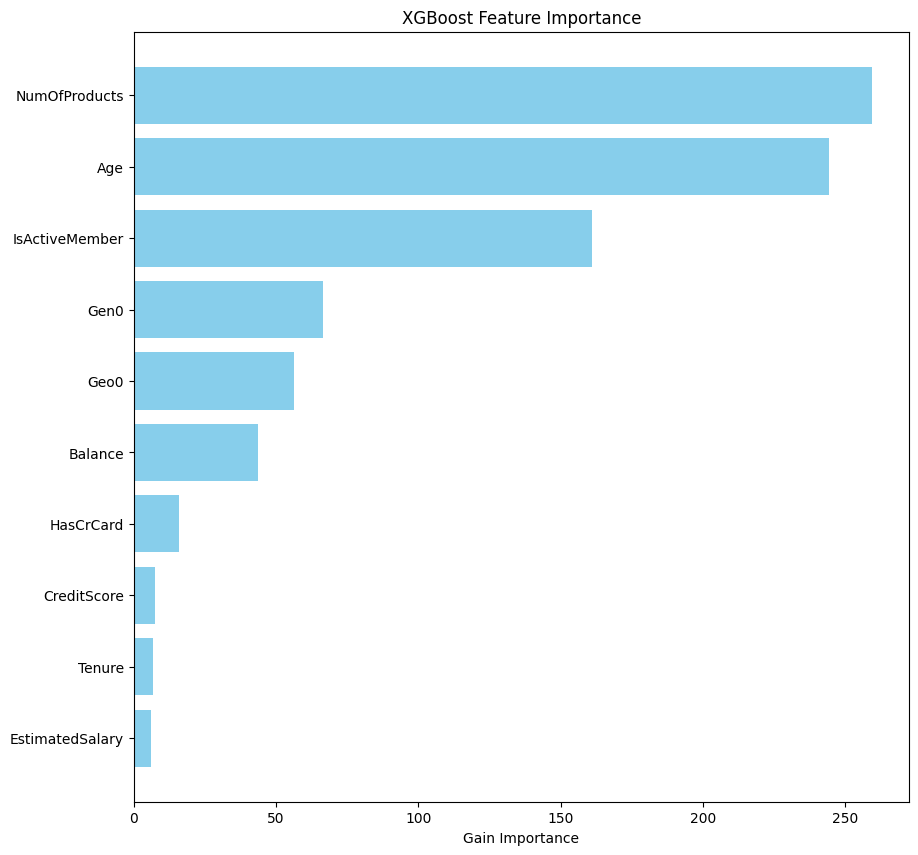

In [36]:
plot_feature_importance(best_xgb, height = 10)

## Explainable AI

In [37]:
import xgboost
xgboost.__version__

'3.1.2'

In [38]:
%pip install shap


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
import shap

/nfs/home/medoro/Churn-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [40]:
booster = best_xgb.get_booster()

In [41]:
val_unscaled_pd = val
val2 = pd.DataFrame(X_val, columns=val.columns, index = val.index)
val_pd_X = val2 # droppa colonne che non ti servono
val_pd_y = y_val_df

In [42]:
explainer = shap.TreeExplainer(booster, feature_perturbation = "interventional" , model_output="probability", data=val_pd_X) 

In [43]:
shap_values = explainer.shap_values(val_pd_X)

 99%|===================| 13770/13969 [00:30<00:00]        

In [44]:
explaination=explainer(val_pd_X)

100%|===================| 13927/13969 [00:29<00:00]        

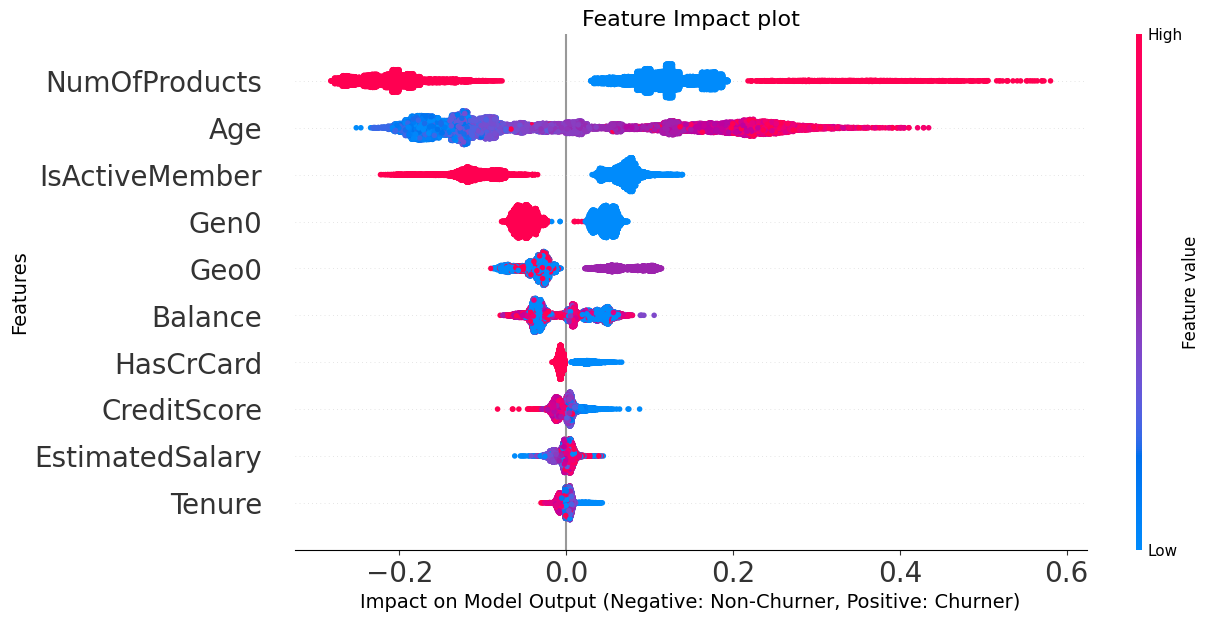

In [45]:
def plot_feature_impact(shap_values, features, feature_names, max_display=10, plot_size=(12,6)):
    fig = plt.figure(figsize=plot_size)

    shap.summary_plot(shap_values=shap_values, 
                      features=features,
                      feature_names=feature_names,
                      max_display=max_display,
                      plot_size=plot_size,
                      show=False)
    plt.title('Feature Impact plot', fontsize=16)
    plt.xlabel('Impact on Model Output (Negative: Non-Churner, Positive: Churner)', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

# Example call
plot_feature_impact(shap_values, val_pd_X, val_pd_X.columns.tolist())

In [46]:
val_shap_values = explainer.shap_values(val_pd_X)
df_temp = pd.DataFrame(val_shap_values)
df_temp['index'] = val_pd_X.index
df_temp.set_index('index', inplace=True)
val_shap_values_df = df_temp

100%|===================| 13921/13969 [00:28<00:00]        

In [47]:
customers_dmatrix = xgboost.DMatrix(
    val_pd_X.values, 
    feature_names=val_pd_X.columns.tolist()
)

customers_prediction = booster.predict(customers_dmatrix)
customers_probability =  1 / (1 + np.exp(-customers_prediction))

In [48]:
new_y = pd.DataFrame(val_pd_y)
new_y['predicted_probability'] = customers_probability
new_y['predicted_prediction'] = customers_prediction

In [49]:
# Voglio tenere tutti i churner che sono stati predetti come tali, quindi con predicted_prediction > 0.5
churners = new_y[(new_y.Exited == 1) & (new_y.predicted_prediction > 0.5)]
churners_X = val_pd_X[val_pd_X.index.isin(churners.index.tolist())]

In [50]:
import random

def extract_customer(test, test_pd_X_tmp, test_pd_y_tmp, test_unscaled_pd):  
    churn_indices = test_pd_y_tmp[test_pd_y_tmp['Exited'] == 1].index
    customer_idx = random.choice(churn_indices.tolist())
    print("Customer Index:", customer_idx)
    customer_pos=test_pd_X_tmp.index.get_loc(customer_idx)
    test_pd_X_tmp=test_pd_X_tmp.reset_index()
    test_pd_y_tmp=test_pd_y_tmp.reset_index()
    customer_x = test_pd_X_tmp[customer_pos:customer_pos+1]
    customer_y = test_pd_y_tmp[customer_pos:customer_pos+1]
    customer_x_original = test_unscaled_pd.loc[customer_idx]
    customer_record = test[test.index == customer_idx]

    return customer_pos,customer_idx,customer_x.set_index('index'), customer_y.set_index('index'), customer_x_original,customer_record

sample_size=30
customer_pos, customer_idx, customer_x, customer_y, customer_x_original,customer_record = extract_customer(val2, churners_X.sample(sample_size,random_state=42), churners.sample(sample_size,random_state=42), val_unscaled_pd)
     

Customer Index: 2669


In [51]:
print(f"\nChurn prediction probability: {customer_y.predicted_prediction.values[0]}")
print(f"Actual churn: {customer_y.Exited.values[0]}")


Churn prediction probability: 0.9764373302459717
Actual churn: 1


In [52]:
customer_shap_values = np.array(val_shap_values_df[val_shap_values_df.index == customer_idx])

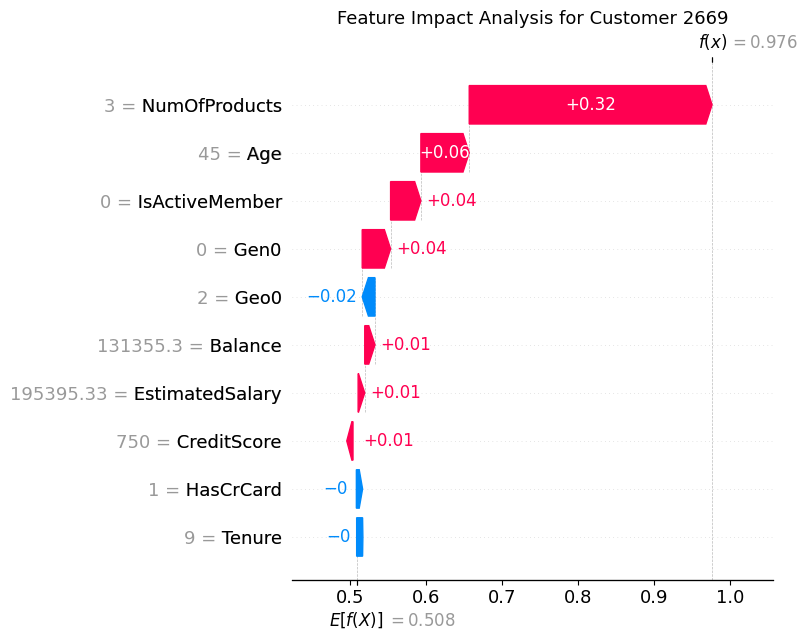

In [53]:
def plot_waterfall(customer_shap_values, explainer_expected_value, customer_x, customer_x_original, customer_prediction, actual_churn, customer_idx, max_display=10):
    plt.figure(figsize=(20, 15))

    shap_values = shap.Explanation(
        values=customer_shap_values[0],
        base_values=explainer_expected_value,
        data=customer_x, #.values[0],
        feature_names=customer_x.columns.tolist(),
        display_data=customer_x_original[customer_x.columns.tolist()]#.values[0]
    )

    shap.plots.waterfall(shap_values, show=False, max_display=max_display)

    plt.title(f"Feature Impact Analysis for Customer {customer_idx}", fontsize=13) #.values[0]

    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()

    plt.tight_layout()

    plt.show()

plot_waterfall(customer_shap_values, explainer.expected_value, customer_x, customer_x_original, new_y[new_y.index == customer_idx].predicted_prediction, 'Yes', customer_idx)